# markdown에서는 "#"이것을 쓰면 그냥 글자만 나중에 보이는데
# "#>##>### 순으로 점점 큰 글자임"

# 행정구역별 의료기관 현황 분석해보기.
## 블록맵을 시각화
### 필요한 데이터 준비물
### 1) 공공보건의료 기관 현황.csv
### 2) 행정구역별 시군구 인구수 엑셀 파일
## 작업
### 1. 행정구역별 주소 수정.
### 2. 행정구역별 의료기관 수 집계
### 3. 행정구역별 인구수 정리
### 4. 테이블 정리, 내부(공통된 행만 뽑아서), 외부(모든 행을 다 합치기)
### 블록맵: 구역의 경계선을 단순화 작업하고, -> 블록(사각형모양으로 ) 그려서 지도에 표기.
### 히트맵으로 온도로 시각화 하는 것과 거의 비슷.

## 데이터 수집
### 준비물)
### 공공데이터 -> 공공보건 의료기관 현황 데이터 csv 다운로드
### 1) 보건복지부 소관 공공보건 의료기관 현황(이렇게 검색)

### 2) 행정구역 시군구 인구수 엑셀파일

In [150]:
import pandas as pd
pd.set_option("mode.chained_assignment", None)
import numpy as np

data=pd.read_csv("./공공보건의료기관현황.csv", index_col=0, encoding="cp949", engine="python")
data

,병원 명,설립형태,근거 법령,관계 행정기관,관계 공공단체,심평원 요양기관번호,종별구분,병상수,소재지 우편번호,주소,홈페이지,대표전화,FAX,비고
연번,,,,,,,,,,,,,,
1,강원도 재활병원,시도립,강원도재활병원설치및운영에관한조례,강원도,해당없음,32200641,병원,165,24227,강원도 춘천시 충열로 142번길 24-16,www.grh.or.kr,033-248-7700,033-248-7723,NaN
2,강원도 삼척의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100060,종합병원,152,25920,강원도 삼척시 오십천로 418,http://ksmc.or.kr,033-572-1141,033-573-8424,NaN
3,강원도 영월의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100078,종합병원,214,26234,강원도 영월군 영월읍 중앙1로 59,http://www.youngwol.org,033-370-9117,033-370-9137,NaN
4,강원도 원주의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100086,종합병원,237,26448,강원도 원주시 서원대로 387(개운동),www.kwmc.or.kr,033-760-4500,033-761-5121,NaN
5,강원도 강릉의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,보건복지부(강원도),지방의료원,32100159,종합병원,137,25535,강원도 강릉시 경강로 2007(남문동 164-1),http://www.gnmc.or.kr,033-646-6910,033-610-1415,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,청풍호노인사랑병원,시군구립,제천시 노인전문병원 설치및 운영에 관한 조례,충청북도,해당없음,33280576,요양병원,187,27207,충청북도 제천시 금성면 청풍호로 1147,www.cplove.co.kr,043-646-0808,043-648-5827,NaN
217,충주시 노인전문병원,시군구립,충주시노인전문병원설치 및 운영에관한 조례,충청북도,해당없음,33280088,요양병원,300,27442,충청북도 충주시 동량면 대전리 1686-28,www.hyolife.com,043-855-9393,043-855-8866,NaN
218,충청북도 충주의료원,특수법인,지방의료원의 설립 및 운영에 관한 법률,충청북도,해당없음,33100063,종합병원,292,27468,충청북도 충주시 안림로 239-50(안림동 134),www.cjmct.or.kr,043-871-0114,043-843-4231,NaN


In [151]:
# 공공 의료기관의 주소 데이터 정리 작업.
# v.split()[:2]) : 인덱스 번호 2번은 포함안되게 0,1까지만 잘라내겠다는 의미
# data["주소"] : "주소"열의 각 행의 내용을 뽑아낸다 / apply: 적용한다
# apply(lambda v : v.split()[:2]).tolist() : 공백기준으로 인덱스 기준이며, 인덱스 0~1까지 잘라서 "주소"뽑아낸 열에 이 내용을 적용한다는 의미
# 기존 csv 파일에서 -> 주소 컬럼에 각각의 행의 내용을 공백을 기준으로 잘라서, 시도, 군구로 뽑는 작업.
addr =pd.DataFrame(data["주소"].apply(lambda v : v.split()[:2]).tolist(), columns=["시도","군구"])
addr.head()

,시도,군구
0,강원도,춘천시
1,강원도,삼척시
2,강원도,영월군
3,강원도,원주시
4,강원도,강릉시


In [152]:
# 해당 주소에서 1차 지역명, 2차 지역명으로 추출후 , 중복 제거 
addr["시도"].unique()

# 창원시 -> 경상남도에 포함, 시도 컬럼에 있으면 안됨, 2차 지역면 군구에 있어야 함. 
# 경산시 -> 경상북도에 포함
# 천안시 -> 충청남도
# 수정해보기. 

# 시도 컬럼을 기준으로 내용이 창원시 를 찾는 부분
addr[addr["시도"] == "창원시"]

# 해당 잘못된 데이터의 행을 수정(재할당)
addr.iloc[27] = ["경상남도", "창원시"]
addr.iloc[27]

addr.iloc[31] = ["경상남도", "창원시"]
addr.iloc[31]

addr[addr["시도"] == "경산시"]
addr.iloc[47] = ["경상북도", "경산시"]
addr.iloc[47]

addr[addr["시도"] == "천안시"]

# 209 , 210
addr.iloc[209] = ["충청남도", "천안시"]
addr.iloc[210] = ["충청남도", "천안시"]
# print(addr.iloc[209])
# print(addr.iloc[210])

addr["시도"].unique()

array(['강원도', '경기도', '경기', '경남', '경상남도', '경상북도', '경북', '인천광역시', '대구광역시',
       '전라남도', '대전광역시', '광주광역시', '제주특별자치도', '부산광역시', '전라북도', '충북',
       '서울특별시', '서울시', '부산특별시', '대전시', '충남', '전남', '충청남도', '울산광역시', '전북',
       '충청북도'], dtype=object)

In [153]:
# 1차 지역명 통일하기
# 강원도 -> 강원특별자치도
# 경기 -> 경기도 
# 경북 -> 경상북도 
# 경남 -> 경상남도
# 충북 -> 충청북도 
# 충남 -> 충청남도
# 전북 -> 전라북도 
# 전남 -> 전라남도
# 서울시 -> 서울특별시
# 대전시 -> 대전광역시 
# 부산특별시 -> 부산광역시

# 딕션너리, key: value 형태로
# addr_alias 로 위에 작업한 내용 중 배열 이름인 지역명 수정할 부분 수정한 것
# "경기"를 "경기도"로 변경의 의미
# "강원도" : "강원특별자치도", 인덱스 일치 하지 않음.
addr_alias = {
  "경기" : "경기도",
  "경기" : "경기도" ,
  "경북" : "경상북도",
  "경남" : "경상남도" ,
  "충북" : "충청북도" ,
  "충남" : "충청남도",
  "전북" : "전라북도" ,
  "전남" : "전라남도",
  "서울시" : "서울특별시",
  "대전시" : "대전광역시", 
  "부산특별시" : "부산광역시"
}
# lambda : 화살표 함수(익명함수)이며, 1회용 함수
# addr_alias.get(v,v) -> v 딕션너리의 키이고, 키에 대한 값이 있다면 변경하고,
# 만약, 키에 대한 값이 없다면 해당 키를 그대로 사용하겠다는 의미.
addr["시도"] = addr["시도"].apply(lambda v: addr_alias.get(v,v))
addr["시도"].unique()


array(['강원도', '경기도', '경상남도', '경상북도', '인천광역시', '대구광역시', '전라남도', '대전광역시',
       '광주광역시', '제주특별자치도', '부산광역시', '전라북도', '충청북도', '서울특별시', '충청남도',
       '울산광역시'], dtype=object)

In [154]:
# 2차 지역명 데이터 확인.
addr["군구"].unique()

# "아란13길" : 제주시로 변경하기.
addr[addr["군구"] == "아란13길"]
addr.iloc[75] = ["제주특별자치도", "제주시"]
addr["군구"].unique()
addr.iloc[75]

시도    제주특별자치도
군구        제주시
Name: 75, dtype: object

In [155]:
# 행정구역별 의료기관 수 확인 하기.
# 새 컬럼 추가. 시도군구
addr["시도군구"] = addr.apply(lambda r: r["시도"]+" "+r["군구"], axis=1)
addr.head()

,시도,군구,시도군구
0,강원도,춘천시,강원도 춘천시
1,강원도,삼척시,강원도 삼척시
2,강원도,영월군,강원도 영월군
3,강원도,원주시,강원도 원주시
4,강원도,강릉시,강원도 강릉시


In [156]:
# addr 위에 주소에, count 컬럼 추가하기.
addr["count"] = 0
addr.head()

,시도,군구,시도군구,count
0,강원도,춘천시,강원도 춘천시,0
1,강원도,삼척시,강원도 삼척시,0
2,강원도,영월군,강원도 영월군,0
3,강원도,원주시,강원도 원주시,0
4,강원도,강릉시,강원도 강릉시,0


In [157]:
# 시도 군구에 대해서 갯수 집계 해보기.
# 이 결과가, 시군구 별 -> 의료기관의 수를 집계
addr_group = pd.DataFrame(addr.groupby(["시도", "군구", "시도군구"], as_index=False).count())
addr_group.head()

,시도,군구,시도군구,count
0,강원도,강릉시,강원도 강릉시,4
1,강원도,동해시,강원도 동해시,1
2,강원도,삼척시,강원도 삼척시,1
3,강원도,속초시,강원도 속초시,1
4,강원도,양구군,강원도 양구군,1


In [158]:
# 인덱스, 시도군구로 설정하기.
# 행정구역별 의료기관 테이블 --------- 행정구역별 인구수 테이블, 조인, 병합하기 위해서,
# 공통의 인덱스 요소를 맞추기(깔 맞춤.)
addr_group = addr_group.set_index("시도군구")
addr_group.head()

,시도,군구,count
시도군구,,,
강원도 강릉시,강원도,강릉시,4
강원도 동해시,강원도,동해시,1
강원도 삼척시,강원도,삼척시,1
강원도 속초시,강원도,속초시,1
강원도 양구군,강원도,양구군,1


In [159]:
# 해당 xlsx 데이터를 불러오기 위해서는 해당 라이브러리가 필요함
# !pip install openpyxl

In [160]:
# 행정구역별 시군구 인구수 엑셀 파일 정리  -> 인구수 , 2023.11 
population = pd.read_excel("./행정구역데이터.xlsx")
population.head()

,행정구역(시군구)별(1),행정구역(시군구)별(2),총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,소계,51337076,25572695,25764381
1,서울특별시,소계,9390925,4543055,4847870
2,서울특별시,종로구,139497,67393,72104
3,서울특별시,중구,121230,58631,62599
4,서울특별시,용산구,214381,102925,111456


In [161]:
# 1차 지역명, 2차 지역명, 모양 맞추기. 
# 	행정구역(시군구)별(1) : 시도
# 	행정구역(시군구)별(2) : 군구
population = population.rename(columns={"행정구역(시군구)별(1)" : "시도","행정구역(시군구)별(2)" : "군구"}) 
population.head()

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,소계,51337076,25572695,25764381
1,서울특별시,소계,9390925,4543055,4847870
2,서울특별시,종로구,139497,67393,72104
3,서울특별시,중구,121230,58631,62599
4,서울특별시,용산구,214381,102925,111456


In [162]:
# 군구 부분에 왼쪽 공백 제거, 새 컬럼 추가 -> 시도군구
# 시도군구 새 컬럼을 -> 인덱스로 설정.
# [element].strip() : 각 행([element])의 공백을 제거한다(strip())는 의미
for element in range (0, len(population)):
  population["군구"][element] = population["군구"][element].strip()

# 시도군구 새 컬럼 추가
population["시도군구"] = population.apply(lambda r: r["시도"] + " " + r["군구"], axis=1) 
population.head()

# 소계 부분 제거하기. 
population = population[population.군구 != "소계"]

# 인덱스 설정.
population = population.set_index("시도군구")
population.head()

,시도,군구,총인구수 (명),남자인구수 (명),여자인구수 (명)
시도군구,,,,,
서울특별시 종로구,서울특별시,종로구,139497,67393,72104
서울특별시 중구,서울특별시,중구,121230,58631,62599
서울특별시 용산구,서울특별시,용산구,214381,102925,111456
서울특별시 성동구,서울특별시,성동구,277701,134760,142941
서울특별시 광진구,서울특별시,광진구,335854,161430,174424


In [163]:
# 데이터 병합 (내부 조인, 인덱스를 기준으로, 같은 행 기준으로 합치기함.  )
# 내부 조인 -> 인덱스를 기준으로, 시도군구의 행이 같은 것들만 모아서 합침. 
# 외부 조인 -> 같은행 상관없이 모두 합치기. 
addr_group.head()
addr_population_merge = pd.merge(addr_group, population, how="inner", left_index=True, right_index=True)
addr_population_merge.head()

,시도_x,군구_x,count,시도_y,군구_y,총인구수 (명),남자인구수 (명),여자인구수 (명)
시도군구,,,,,,,,
경기도 가평군,경기도,가평군,1,경기도,가평군,62131,32039,30092
경기도 고양시,경기도,고양시,4,경기도,고양시,1075089,524514,550575
경기도 남양주시,경기도,남양주시,5,경기도,남양주시,732086,363169,368917
경기도 동두천시,경기도,동두천시,1,경기도,동두천시,88787,44272,44515
경기도 부천시,경기도,부천시,1,경기도,부천시,781119,386234,394885


In [164]:
# 필요한 컬럼만 추출, 총 4개의 컬럼이 필요함
# 행정구역별 의료기관의 인구수 대비의 비율을 구하는게 목적.
# count -> 의료기관 수
# 시도_x  군구_x  count    총인구수(명)
local_Hosptial_Population = addr_population_merge[["시도_x", "군구_x", "count", "총인구수 (명)"]]
local_Hosptial_Population.head()

,시도_x,군구_x,count,총인구수 (명)
시도군구,,,,
경기도 가평군,경기도,가평군,1,62131
경기도 고양시,경기도,고양시,4,1075089
경기도 남양주시,경기도,남양주시,5,732086
경기도 동두천시,경기도,동두천시,1,88787
경기도 부천시,경기도,부천시,1,781119


In [165]:
# 컬럼 이름 조정, 인구수 대비 의료기관 비율 새컬럼 추가.
local_Hosptial_Population = local_Hosptial_Population.rename(columns={"시도_x": "시도", "군구_x": "군구", "총인구수 (명)" : "인구수"})
local_Hosptial_Population.head()

# 새 컬럼 HS_ratio : (병원의 숫자/인구수)*100000 = 비율
HS_count = local_Hosptial_Population["count"]
local_Hosptial_Population["HS_ratio"] = HS_count.div(local_Hosptial_Population["인구수"], axis=0)*100000
local_Hosptial_Population.head()

,시도,군구,count,인구수,HS_ratio
시도군구,,,,,
경기도 가평군,경기도,가평군,1,62131,1.609503
경기도 고양시,경기도,고양시,4,1075089,0.372062
경기도 남양주시,경기도,남양주시,5,732086,0.682980
경기도 동두천시,경기도,동두천시,1,88787,1.126291
경기도 부천시,경기도,부천시,1,781119,0.128021


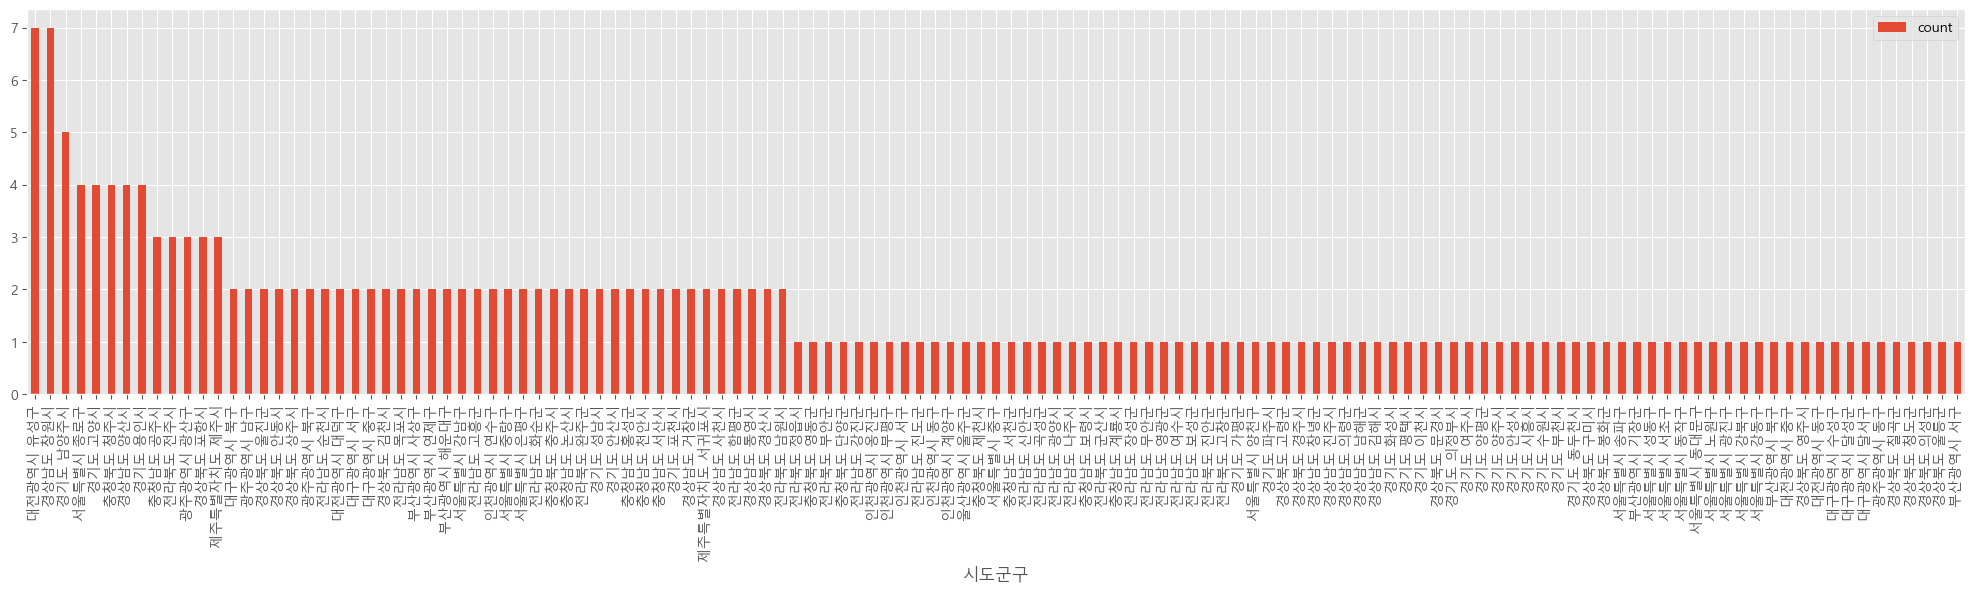

In [166]:
# 막대 그래프만 그리기.
# 블록맵은 추가 설정이 필요해서, 다음시간에..

# "c:/Windows/Fonts/malgun.ttf" : 기본 폰트
from matplotlib import pyplot as plt 
from matplotlib import rcParams, style
# R 프로그래밍 -> 시각화를 할 때, 해당 그림의 속성을 좀더 편하게 지정하는 템플릿
# gg -> gramar graph, 도표를 작성 시 필요한 구문(문법) -> 도표, 크기, 색깔, 폰트, 등
style.use("ggplot")

# 폰트를 지정. font_manager
# rc -> runtime configuration, 표의 속성을 전역으로 설정하는 모듈(도구)
# 한번, 표에 관련된 설정을 해두면, 밑에서 다른 도표에서 사용시, 전역으로 설정이 되었으니, 따로 할 필요가 없다.
from matplotlib import font_manager, rc 
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgunbd.ttf").get_name()
rc("font", family = font_name)

# local_Hosptial_Population["count"] -> 반환값 시리즈, 시리즈(행, 열 1개로 표현을 하는 타입)
# local_Hosptial_Population[["count"]] -> 반환값 데이터 프레임(표)
HS_ratio = local_Hosptial_Population[["count"]]
# HS_ratio -> 타입: DataFrame 표.
# count 컬럼의 값들을, 오름차순(ascending) False -> 내림차순
HS_ratio = HS_ratio.sort_values("count", ascending=False)
# 30, 단위 인치
plt.rcParams["figure.figsize"] = (25,5)
# kind = "bar" : 차트 종료(바 차트) , rot = "vertical" : x 라벨 표기의 기울기
HS_ratio.plot(kind = "bar", rot = "vertical")
plt.show()

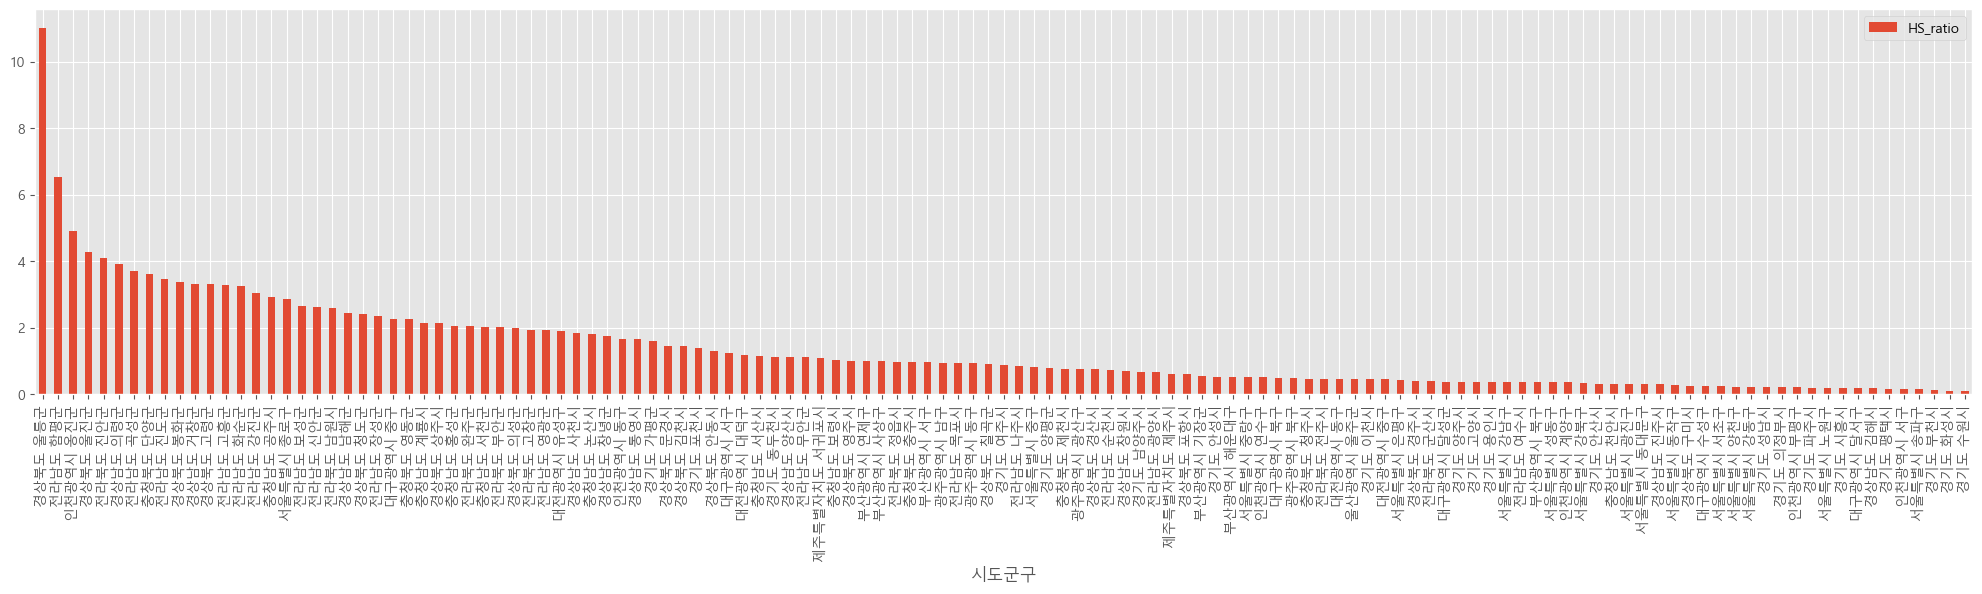

In [167]:
HS_ratio = local_Hosptial_Population[["HS_ratio"]]
# HS_ratio -> 타입 : DataFrame 표. 
# count 컬럼의 값들을 , 오름 차순 False -> 내림 차순, 
HS_ratio = HS_ratio.sort_values("HS_ratio", ascending=False)
# 30 , 단위 인치, 
plt.rcParams["figure.figsize"] = (25,5)
# rot = 80, x 라벨의 표기의 기울기
HS_ratio.plot(kind = "bar", rot = 90)
plt.show()

In [168]:
# 블록맵 준비
# 블록맵을 구성하는, 각 지역마다, 특정의 임의의 좌표로한 데이터가 필요.
# 블록맵을 경계를 나눌 샘플 좌표 데이터가 필요.
# 데이터 출처를 조사, 

# 준비물 1 : data_draw_korea.csv
# 준비물 2
BORDER_LINES = [ [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천 [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울 [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9), (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도 [(9, 12), (9, 10), (8, 10)], # 강원도 [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5), (13, 4), (14, 4), (14, 2)], # 충청남도 [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7), (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도 [(14, 4), (15, 4), (15, 6)], # 대전시 [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도 [(14, 8), (16, 8), (16, 10), (15, 10), (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시 [(15, 11), (16, 11), (16, 13)], # 울산시 [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도 [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시 [(18, 5), (20, 5), (20, 6)], # 전라남도 [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시 ]

In [169]:
import os
# 현재 작업 중 폴더 경로 불러오기.
path = os.getcwd()
path

'c:\\BigDataTest\\My_Python\\BigdataVisualization_analyze_teacher\\3-지도맵-통계'

In [170]:
# 준비물 1번 메모리에 올리기.
# index_col=0 -> 첫번째 열을, 데이터프레임의 인덱스로 사용함.
data_draw_korea = pd.read_csv(path+"\\data_draw_korea.csv", index_col=0, encoding="utf-8", engine="python")
data_draw_korea.head()

,인구수,shortName,x,y,면적,광역시도,행정구역
0,202520,강릉,11,4,1040.07,강원도,강릉시
1,25589,고성(강원),9,0,664.19,강원도,고성군
2,86747,동해,11,5,180.01,강원도,동해시
3,63986,삼척,11,8,1185.80,강원도,삼척시
4,76733,속초,9,1,105.25,강원도,속초시


In [171]:
# 행정 구역 지역명 추출 작업
# 광역시도 열, 행정구역 열 추출해서, 새로운 시도군구 열을 추가하기.
data_draw_korea["시도군구"] = data_draw_korea.apply(lambda r: r["광역시도"]+" "+ r["행정구역"], axis=1)
data_draw_korea.head()

,인구수,shortName,x,y,면적,광역시도,행정구역,시도군구
0,202520,강릉,11,4,1040.07,강원도,강릉시,강원도 강릉시
1,25589,고성(강원),9,0,664.19,강원도,고성군,강원도 고성군
2,86747,동해,11,5,180.01,강원도,동해시,강원도 동해시
3,63986,삼척,11,8,1185.80,강원도,삼척시,강원도 삼척시
4,76733,속초,9,1,105.25,강원도,속초시,강원도 속초시


In [172]:
# 데이터 프레임 병합 하려면, 인덱스 동일하게 맞추는 작업(깔 맞춤)
# 시도군구 열 -> 인덱스로 설정.
data_draw_korea = data_draw_korea.set_index("시도군구")
data_draw_korea.head()

,인구수,shortName,x,y,면적,광역시도,행정구역
시도군구,,,,,,,
강원도 강릉시,202520,강릉,11,4,1040.07,강원도,강릉시
강원도 고성군,25589,고성(강원),9,0,664.19,강원도,고성군
강원도 동해시,86747,동해,11,5,180.01,강원도,동해시
강원도 삼척시,63986,삼척,11,8,1185.80,강원도,삼척시
강원도 속초시,76733,속초,9,1,105.25,강원도,속초시


In [173]:
# data_draw_korea 의 테이블, 기존에 사용하던, local_Hosptial_Population, 
# 조인(저 두 테이블을 합침), 외부조인 -> 해당 조건에서 값이 일치하지 않는 행까지 모두 다 합침.
# 만약, 해당 값이 없다면 -> NaN으로 집계가 됨.

data_draw_korea_local_Hosptial_Population = pd.merge(data_draw_korea, local_Hosptial_Population, how="outer", left_index=True, right_index=True)

data_draw_korea_local_Hosptial_Population.head()
# data_draw_korea_local_Hospital_Population[["광역시도","행정구역"]]

,인구수_x,shortName,x,y,면적,광역시도,행정구역,시도,군구,count,인구수_y,HS_ratio
시도군구,,,,,,,,,,,,
강원도 강릉시,202520,강릉,11,4,1040.07,강원도,강릉시,NaN,NaN,NaN,NaN,NaN
강원도 고성군,25589,고성(강원),9,0,664.19,강원도,고성군,NaN,NaN,NaN,NaN,NaN
강원도 동해시,86747,동해,11,5,180.01,강원도,동해시,NaN,NaN,NaN,NaN,NaN
강원도 삼척시,63986,삼척,11,8,1185.80,강원도,삼척시,NaN,NaN,NaN,NaN,NaN
강원도 속초시,76733,속초,9,1,105.25,강원도,속초시,NaN,NaN,NaN,NaN,NaN


In [174]:
# 준비물 2번 -> 지도에, 각 2차 지역을 사각형(블록)을 나누는 경계선 좌표.
BORDER_LINES = [
   [(3, 2), (5, 2), (5, 3), (9, 3), (9, 1)], # 인천 [(2, 5), (3, 5), (3, 4), (8, 4), (8, 7), (7, 7), (7, 9), (4, 9), (4, 7), (1, 7)], # 서울 [(1, 6), (1, 9), (3, 9), (3, 10), (8, 10), (8, 9), (9, 9), (9, 8), (10, 8), (10, 5), (9, 5), (9, 3)], # 경기도 [(9, 12), (9, 10), (8, 10)], # 강원도 [(10, 5), (11, 5), (11, 4), (12, 4), (12, 5), (13, 5), (13, 4), (14, 4), (14, 2)], # 충청남도 [(11, 5), (12, 5), (12, 6), (15, 6), (15, 7), (13, 7), (13, 8), (11, 8), (11, 9), (10, 9), (10, 8)], # 충청북도 [(14, 4), (15, 4), (15, 6)], # 대전시 [(14, 7), (14, 9), (13, 9), (13, 11), (13, 13)], # 경상북도 [(14, 8), (16, 8), (16, 10), (15, 10), (15, 11), (14, 11), (14, 12), (13, 12)], # 대구시 [(15, 11), (16, 11), (16, 13)], # 울산시 [(17, 1), (17, 3), (18, 3), (18, 6), (15, 6)], # 전라북도 [(19, 2), (19, 4), (21, 4), (21, 3), (22, 3), (22, 2), (19, 2)], # 광주시 [(18, 5), (20, 5), (20, 6)], # 전라남도 [(16, 9), (18, 9), (18, 8), (19, 8), (19, 9), (20, 9), (20, 10)], # 부산시 ]
]

In [175]:
# 힘든 작업, 블록 맵을 그리기 위한 함수를 설정.
# 이미 만들어진 함수를 재사용.
# blockedMap : 원본 데이터 프레임,
# ex) data_draw_korea_local_Hosptial_Population : 외부 조인한 원본 데이터
# targetData :  내가 찾고자하는 결과데이터(종속변수)
# 예) 의료기관의 수 : count, 인구수 대비 의료기관의 비율 : HS_ratio 이 두개가 들어감
# title, color : 도표의 제목과 색깔
def draw_blockMap(blockedMap, targetData, title, color):
  # 블록맵의 각 구역의 색깔을 지정시, 최소 비율 -> 흰색에 가까운 임의의 비율 색.
  # 히트맵에서, 연관관계가 높으면 색깔이 진한색(빨간, 파란)
  whitelabelmin = (max(blockedMap[targetData])-min(blockedMap[targetData]))*0.25
  + min(blockedMap[targetData])
  # test 샘플값 (최대,최소값이 못 잡아서 색 구분이 안되서 임의로 지정해서 색 구분함)
  whitelabelmin = 2.5
  print(f"whitelabelmin : {whitelabelmin}")

  # 라벨 이름
  datalabel = targetData

  # vmin, vmax, ->  색깔을 표현하기 위한 최소, 최대값으로 활용할 예정.
  #(최대,최소값이 못 잡아서 색 구분이 안되서 임의로 지정해서 색 구분함)
  vmin = min(blockedMap[targetData])
  vmin = 1.0
  print(f"vmin : {vmin}")
  vmax = max(blockedMap[targetData])
  vmax = 7.0
  print(f"vmax : {vmax}")

  # pivot 함수를 이용해서, 기존의 행과 열을, 새로운 데이터프레임(테이블)로 재배치하는 함수.
  # index = "y" : 행, columns = "x" : 열, 그 안에 값으로 : targetData
  mapdata = blockedMap.pivot(index = "y", columns = "x", values = targetData)
  print(f"mapdata : {mapdata}")

  # 전처리, NaN 없애기.
  #  np.ma.masked_where(각 데이터의 NaN의 존재여부 True False 판단, mapdata)
  # np.isnan(mapdata) -> pivot라는 함수로 새롭게 만들어진 테이블에서, nan 다 조사해서,
  # 그 결과를 True, False로 다 반환.
  # masked_mapdata -> nan이 다 제거된 테이블.
  masked_mapdata = np.ma.masked_where(np.isnan(mapdata), mapdata)
  print(f"masked_mapdata : {masked_mapdata}")

  # 그래프 옵션
  # 8인치, 13인치
  plt.figure(figsize=(8,13))
  # 제목은 함수의 인자값으로 들어오게 됨.
  plt.title(title)

  # 그래프 색깔. cmap = color -> 인자값으로 받을 예정, 빨강, 파랑
  plt.pcolor(masked_mapdata, vmin= vmin, vmax=vmax, cmap = color, edgecolor = "#aaaaaa", linewidth = 0.5)

  # 지역 이름표시.
  # 원본 데이터를 반복문을 전체 조회를 해서, 각 지역명을 표기하는 방식
  # idx : 각 행의 인덱스, row : 각 행
  for idx, row in blockedMap.iterrows():
    # 지도에 표시되는 지역명, 주석처리 사용이 되는 옵션 설정.
    annocolr = "white" if row[targetData] > whitelabelmin else "black"

    # 광역시 = 시도, 행정구역 = 군구,
    # 부산에 강서구, 서울에도 강서구가 있음.
    # 동구, 서구, 남구, 북구는 모든 광역시 지역에 동일하게 있어 겹침.
    # 2차 지역명으로만 표기시, 중복이 되므로, 1차 지역명과 같이 표기하는 방법.

    # ex) 부산광역시,
    # 부산,
    # 서구
    # row["광역시도"][:2] , 2인 끝은 미포함, 인덱스 0,1만 해당ex) 부산광역시 -> "부산" 추출
    # row["행정구역"][:-1], [:-1]: 맨마지막 의미 미포함, 맨마지막 한글자 제외하고 전부 가져옴
    # ex) 강릉시 -> 강릉
    # row["행정구역"][-1], [-1]: 마지막 글자를 의미함.
    # ex) 강릉시 -> 시
    if row["광역시도"].endswith("시") and not row["광역시도"].startswith("세종"):
      dispname = "{}\n{}".format(row["광역시도"][:2], row["행정구역"][:-1])
      if len(row["행정구역"]) <= 2:
        dispname += row["행정구역"][-1]
    else:
      dispname = row["행정구역"][:-1]
    
    # 글자 크기 조정하기. 2글자 조금 크게, 3글자 조금 작게 조정하기.
    if len(dispname.splitlines()[-1]) >= 3:
      fontsize, linespacing = 9.5, 1.5
    else:
      fontsize, linespacing = 11, 1.2

    # 주석의 위치 조정하기. 폰트 크기, 색 설정, 굵기 등..
    # ha = "center" : 수평간격 / va = "center" : 수직간격
    plt.annotate(dispname, (row["x"]+0.5, row["y"]+0.5), weight = "bold", fontsize = fontsize, ha = "center", va = "center", color = annocolr, linespacing=linespacing)

  # 라인의 경계 그리기,
  for path in BORDER_LINES:
    # zip, 같은 인덱스끼리 묶기,
    # *path, 언패킹, 각각의 변수에 할당.
    ys, xs = zip(*path)
    plt.plot(xs,ys, c= "black", lw=4)

  # gca, get current axe, 현재 축을 선택
  # y 축 반전하는 함수, invert_yaxis() -> 예) 원래 y로 위로 갈수록 커지는 속성 기본.
  # 반전, y가 커질수록, 아래로 향하게 하는 속성.
  plt.gca().invert_yaxis()
  # x축, y축 표기 여부
  plt.axis("off")
  # 그래프 오른쪽의 각 색깔별 막대 그래프, shrink 크기, aspect 종횡비율, 각 구간 범위.
  cb = plt.colorbar(shrink =1, aspect = 10)
  #
  cb.set_label(datalabel)

  # 내부 요소가 겹치지 않게 그리기.
  plt.tight_layout()
  # 결과 화면, 이미지 파일로 저장하기.
  plt.savefig("./blockMap_"+ targetData + ".png")


whitelabelmin : 2.5
vmin : 1.0
vmax : 7.0
mapdata : x    0    1    2    3    4    5    6    7    8    9    10   11   12   13
y                                                                       
0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1   NaN  NaN  NaN  NaN  NaN  NaN  1.0  NaN  2.0  NaN  NaN  NaN  NaN  NaN
2   NaN  NaN  NaN  1.0  4.0  1.0  NaN  1.0  1.0  NaN  NaN  NaN  NaN  NaN
3   NaN  NaN  NaN  NaN  2.0  NaN  4.0  1.0  5.0  1.0  NaN  NaN  NaN  NaN
4   NaN  1.0  1.0  NaN  NaN  NaN  1.0  1.0  2.0  NaN  NaN  NaN  NaN  NaN
5   NaN  1.0  1.0  1.0  1.0  1.0  NaN  1.0  1.0  NaN  NaN  NaN  NaN  NaN
6   NaN  NaN  1.0  2.0  NaN  NaN  1.0  1.0  1.0  1.0  NaN  NaN  NaN  1.0
7   NaN  NaN  NaN  1.0  NaN  NaN  2.0  NaN  NaN  1.0  NaN  NaN  NaN  NaN
8   1.0  2.0  NaN  NaN  1.0  NaN  NaN  2.0  1.0  1.0  NaN  NaN  NaN  NaN
9   NaN  NaN  NaN  NaN  2.0  1.0  1.0  4.0  2.0  NaN  1.0  1.0  2.0  NaN
10  NaN  2.0  2.0  NaN  3.0  NaN  2.0  1.0  1.0  1.0  2.0  NaN  NaN  NaN

C:\Users\it\AppData\Local\Temp\ipykernel_652\3557549939.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(shrink =1, aspect = 10)


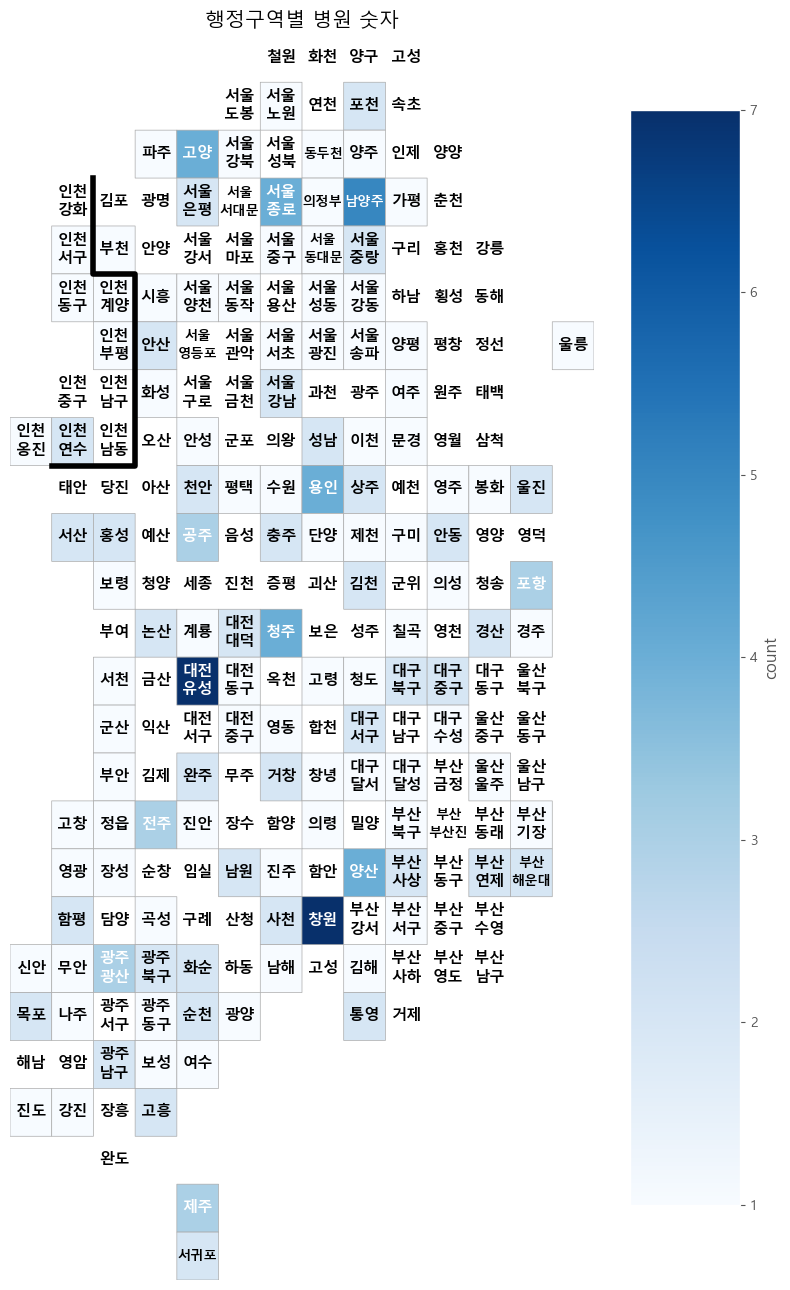

In [176]:
# 함수 이용해서 블록맵 그려보기.
draw_blockMap(data_draw_korea_local_Hosptial_Population, "count", "행정구역별 병원 숫자", "Blues")

whitelabelmin : 2.5
vmin : 1.0
vmax : 7.0
mapdata : x         0         1         2         3         4         5         6   \
y                                                                          
0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1        NaN       NaN       NaN       NaN       NaN       NaN  0.200410   
2        NaN       NaN       NaN  0.200894  0.372062  0.346338       NaN   
3        NaN       NaN       NaN       NaN  0.428295       NaN  2.867445   
4        NaN  0.160448  0.128021       NaN       NaN       NaN  0.824878   
5        NaN  1.675182  0.355792  0.192458  0.229108  0.263723       NaN   
6        NaN       NaN  0.203708  0.317133       NaN       NaN  0.245039   
7        NaN       NaN       NaN  0.106215       NaN       NaN  0.369597   
8   4.892847  0.510290       NaN       NaN  0.528701       NaN       NaN   
9        NaN       NaN       NaN       NaN  0.304607  0.169438  0.083525   
10       NaN  1.135854  2.051766    

C:\Users\it\AppData\Local\Temp\ipykernel_652\3557549939.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar(shrink =1, aspect = 10)


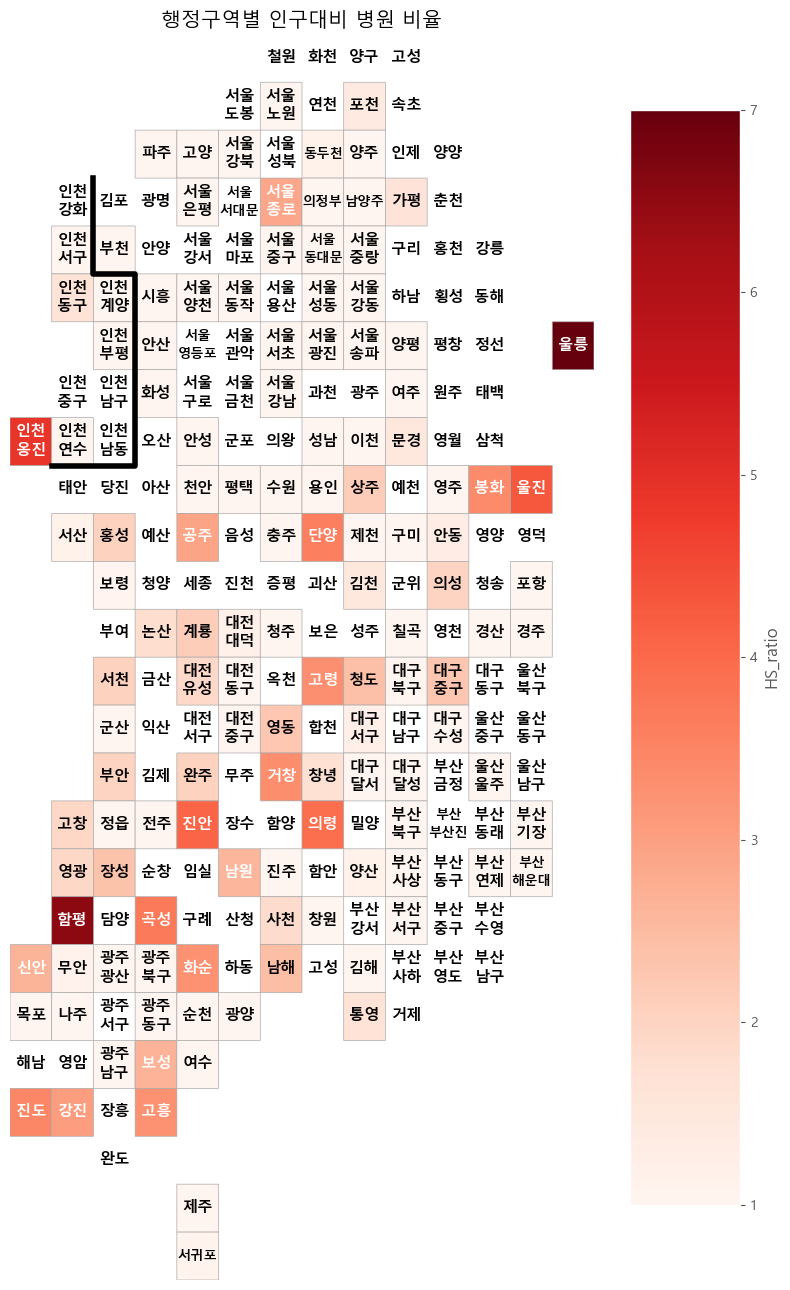

In [177]:
# 함수 이용해서 블록맵 그려보기. 
draw_blockMap(data_draw_korea_local_Hosptial_Population,"HS_ratio","행정구역별 인구대비 병원 비율", "Reds")